In [10]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.pairwise import pairwise_kernels
import networkx as nx
from TracyWidom import TracyWidom
from numpy import linalg as LA

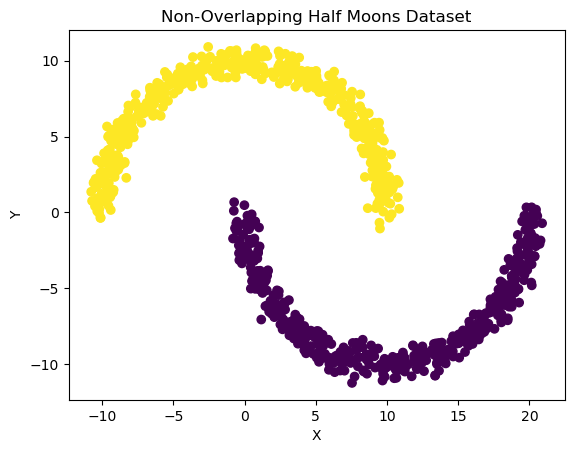

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generate non-overlapping half moons dataset
n_samples = 1000

# Parameters for upper half moon
radius_upper = 10
theta_upper = np.linspace(0, np.pi, n_samples // 2)

# Generate upper half moon
upper_x = radius_upper * np.cos(theta_upper)
upper_y = radius_upper * np.sin(theta_upper)
upper_half_moon = np.column_stack((upper_x, upper_y))

# Parameters for lower half moon
radius_lower = 10
theta_lower = np.linspace(np.pi, 2 * np.pi, n_samples // 2)

# Generate lower half moon
lower_x = radius_lower + radius_lower * np.cos(theta_lower)
lower_y = radius_lower * np.sin(theta_lower)
lower_half_moon = np.column_stack((lower_x, lower_y))

# Combine upper and lower half moons
dataset = np.vstack((upper_half_moon, lower_half_moon))
dataset+= np.random.randn(n_samples, 2) * 0.5

# Generate labels
labels = np.concatenate((np.ones(n_samples // 2), np.zeros(n_samples // 2)))

# Plot the dataset
plt.scatter(dataset[:, 0], dataset[:, 1], c=labels)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Non-Overlapping Half Moons Dataset')
plt.show()


In [2]:
data = dataset

In [3]:
def knn_adjacency(data,neighbors):
    A = kneighbors_graph(data, neighbors, mode='connectivity', include_self=False).toarray()
    Adj = np.minimum(A + A.transpose(),1)
    return(Adj)

def eps_adjacency(data,epsilon):
    distances = cdist(data, data, metric='euclidean')
    Adj = np.where(distances <= epsilon, 1, 0)
    return(Adj)

def rbf_adjacency(data,epsilon):
    Adj = pairwise_kernels(data, metric=rbf, epsilon=epsilon)
    return(Adj)

def rbf(x,y,epsilon):
    z = np.exp(-epsilon*np.sum((x-y)**2))
    return(z)

In [ ]:
calculate_matrices(data, epsilon=0.5, neighbors=0, kernel='eps')

In [4]:
def calculate_matrices(data, epsilon, neighbors, kernel):
    
    # adjacency matrix
    if kernel=='knn':
        adjacency_matrix = knn_adjacency(data,neighbors)
    elif kernel=='eps':
        distances = cdist(data, data, metric='euclidean')
        adjacency_matrix = eps_adjacency(data,epsilon)
    elif kernel=='rbf':
        adjacency_matrix = rbf_adjacency(data,epsilon)
    
    # degree matrix
    degree_vector = np.sum(adjacency_matrix, axis=1)
    degree_matrix = np.diag(degree_vector)
    #print(degree_vector)

    # Laplacian matrix
    degree_inverse_sqrt = np.sqrt(1 / degree_vector)
    laplacian_matrix = np.eye(data.shape[0]) - degree_inverse_sqrt[:, np.newaxis] * adjacency_matrix * degree_inverse_sqrt[np.newaxis, :]

    return adjacency_matrix, degree_matrix, laplacian_matrix

In [5]:
def perform_multiple_cuts(data, degree_matrix, laplacian_matrix, n_clusters):

    n_points, n_dimensions = data.shape
    min_Li_n = np.inf

    for i in range(n_dimensions):
        for n in range(n_points-1):
            split_value = data[n, i]
            #print('Cut dimension',i,'at',split_value)
            x_left = data[data[:, i] <= split_value,:]
            x_right = data[data[:, i] > split_value,:]
            volume_left = np.sum(degree_matrix[np.ix_(data[:, i] <= split_value, data[:, i] <= split_value)])
            volume_right = np.sum(degree_matrix[np.ix_(data[:, i] > split_value, data[:, i] > split_value)])
            fm = np.zeros(n_points)
            fm[data[:, i] <= split_value] = np.sqrt(volume_left / volume_right)
            fm[data[:, i] > split_value] = -np.sqrt(volume_right / volume_left)
            Li_n = np.dot(fm.T, np.dot(laplacian_matrix, fm))
            #print('This gives a cost of', Li_n)
            if Li_n < min_Li_n:
                min_Li_n = Li_n
                splits = [x_left, x_right]

    return splits

In [6]:
def Test_Hypothesis(points, delta, n_k):
    test_result = points > n_k*(1+delta)
    return test_result

def Test_Hypothesis2(A,signif):
    
    n = A.shape[0]
    tw1 = TracyWidom(beta=1)
    p_hat = np.sum(A)/(n*(n-1))
    P_hat = p_hat*(np.ones((n,n)) - np.eye(n))
    A_tilde = (A - P_hat)/np.sqrt((n-1)*p_hat*(1-p_hat))
    eigenvalues, eigenvectors = LA.eigh(A_tilde)
    eigen_max = max(eigenvalues)
    test_statistic = n**(2/3)*(eigen_max-2)
    p_value = 1-tw1.cdf(test_statistic)
    test_result = signif > p_value
    
    return test_result

In [22]:
keepsplitting  = 1
datasets = [data]

n_k = data.shape[0] # number of points per cluster

while keepsplitting > 0:
    splits  = np.zeros(len(datasets))
    #print(splits)
    datasets2 = datasets.copy()
    for i in range(len(datasets)):
        adj, deg, lap = calculate_matrices(datasets[i], epsilon = 0., neighbors=2, kernel='eps')
        #check_hypo = Test_Hypothesis(len(datasets[i]),0.2,n_k)
        check_hypo = Test_Hypothesis2(adj,signif=0.05)
        print(check_hypo)
        if check_hypo==True:
            splits[i] = 1
        else:
            splits[i] = 0
        if check_hypo == True:
            left, right = perform_multiple_cuts(datasets[i], deg, lap, n_clusters=2) 
            print(len(left))
            print(len(right))
            datasets2[i] = left
            datasets2.append(right)

    print(splits)
    datasets = datasets2
    keepsplitting = np.sum(splits)
    print(keepsplitting)
    print('/////////')

True


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16928\3087484997.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  fm[data[:, i] <= split_value] = np.sqrt(volume_left / volume_right)


450
550
[1.]
1.0
/////////
True
246
204
True
339
211
[1. 1.]
2.0
/////////
True
134
112
True
170
169
True
90
114
True
82
129
[1. 1. 1. 1.]
4.0
/////////
True
133
1
True
158
12
True
62
28
True
54
28
True
54
58
True
63
106
True
57
57
True
7
122
[1. 1. 1. 1. 1. 1. 1. 1.]
8.0
/////////
True
132
1
True
1
157
True
4
58
True
16
38
True
9
45
True
60
3
True
29
28
False
False
False
True
16
12
True
21
7
True
17
41
False
True
54
3
False
[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0.]
11.0
/////////
True
131
1
False


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16928\1274151502.py:9: RuntimeWarning: divide by zero encountered in long_scalars
  p_hat = np.sum(A)/(n*(n-1))
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16928\1274151502.py:10: RuntimeWarning: invalid value encountered in multiply
  P_hat = p_hat*(np.ones((n,n)) - np.eye(n))
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16928\1274151502.py:11: RuntimeWarning: invalid value encountered in double_scalars
  A_tilde = (A - P_hat)/np.sqrt((n-1)*p_hat*(1-p_hat))
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16928\1274151502.py:11: RuntimeWarning: invalid value encountered in sqrt
  A_tilde = (A - P_hat)/np.sqrt((n-1)*p_hat*(1-p_hat))


LinAlgError: Eigenvalues did not converge